This notebooks purpose is to visualise the tidal ellipses along the thalweg.

In [31]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import re

import netCDF4 as nc
from scipy.optimize import curve_fit
import scipy.io as sio
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

#Load the parameters
The thalweg had 1539 pair of points. I chose 15 stations at increments of 100 points along the thalweg and calculated the tidal ellipse parameters for these locations

In [32]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

In [36]:
u = sio.loadmat('/ocean/mdunn/Tides/u_foreman.mat')['u']
v = sio.loadmat('/ocean/mdunn/Tides/v_foreman.mat')['v']
time1 = 735929
time2 = 736139+1

time = np.arange(0,time2-time1)
params_f = np.zeros((5,4))
for r in np.arange(0,4):
    uM2amp, uM2pha, uK1amp, uK1pha = tidetools.fittit(u[r], time)
    vM2amp, vM2pha, vK1amp, vK1pha = tidetools.fittit(v[r], time)
    CX, SX, CY, SY, ap, am, ep, em, major, minor, theta, phase = tidetools.ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha)
    CX_k, SX_k, CY_k, SY_k, ap_k, am_k, ep_k, em_k, major_k, minor_k, theta_k, phase_k = tidetools.ellipse_params (uK1amp, uK1pha, vK1amp, vK1pha)
    params_f[r,:] = [major/100, minor/100, theta, phase]

In [37]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 24)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
loc = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1400, 1500]
count = np.arange(0,15)
params = np.zeros((15,39,5))
params_av = np.zeros((15,8))
cols=np.arange(0,5)

i = np.zeros((15))
j = np.zeros((15))

for k,l in zip(loc,count):
    i = thalweg[1,loc]
    j = thalweg[0,loc]
    runname1 = '{}_{}_thalweg_{}'.format(t_o, t_f, k)
    runname2 = '{}_{}_thalweg_{}_depav(20-200)'.format(t_o, t_f, k)
    df1 = pd.read_csv(runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv(runname2+'.csv', index_col=False)
    params[l,:,:] = df1.as_matrix()
    params_av[l,:] = df2.as_matrix()


##Plot of locations

(898, 398)


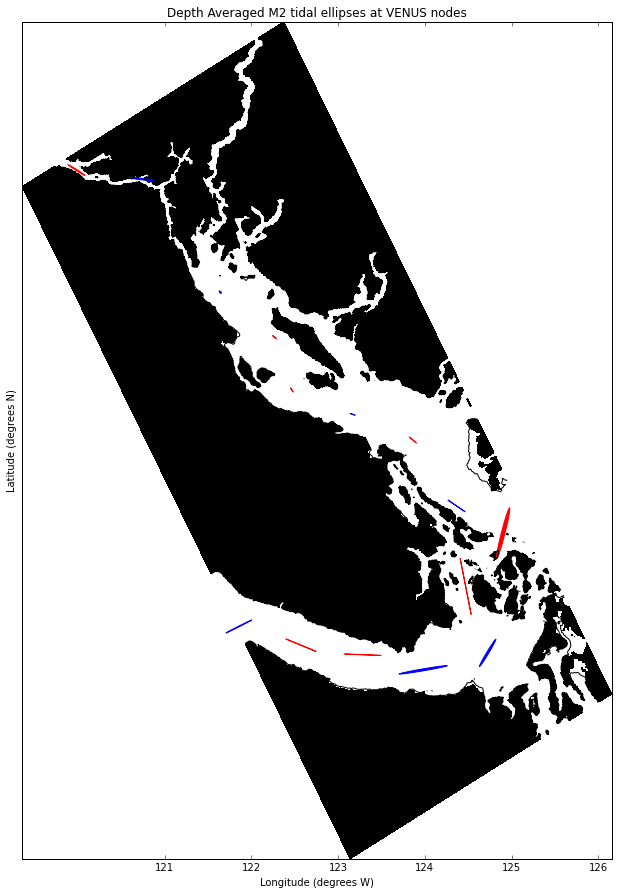

In [38]:
phi=29
fig = plt.figure(figsize=(15,15))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 0

imin=0
imax = 330

jmin = 150
jmax = 895

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
scale = 75

#Making the ellipse for the Central node

count = np.arange(0,15)

for loc, r, l in zip(count, i ,j):
    if params_av[loc,1] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[l,r],k[l,r]), width=scale*params_av[loc,0], 
                        height=scale*params_av[loc,1], angle=params_av[loc,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude
#ax.set_ylim(300,350)
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(44, 50, 0.5)-
                           lats[jmin,imin])/slope).tolist()
labels = ['44.5','45','45.5','46','47','48', '49','50']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
#ax.set_xlim(100,120)
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-127,-120.5,1)-
                        lons[jmin,imin])/slope).tolist()
labels = ['127','126','125','124','123','122','121', '120']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')
print bathy.data.shape

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at VENUS nodes')


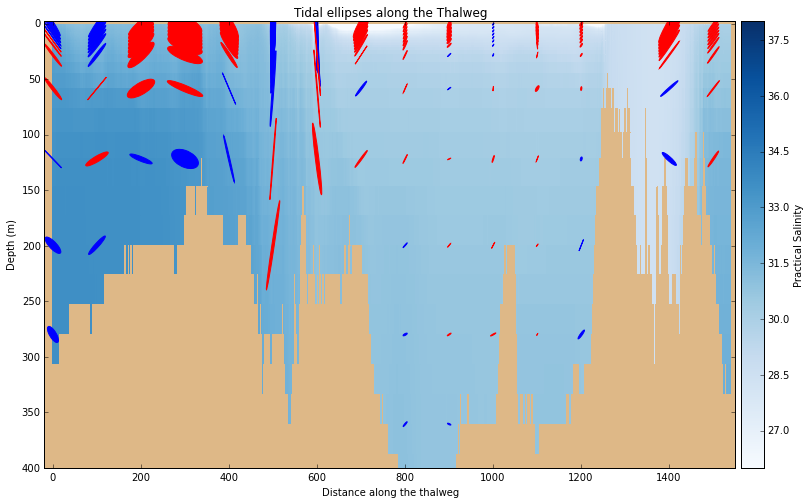

In [39]:
# Set up the figure and axes
fig, (axl, axcb) = plt.subplots(1, 2, figsize=(16, 8))
land_colour = 'burlywood'
axl.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))

smin, smax, dels = 26, 38, 0.5
cmap = plt.get_cmap('Blues')
cmap.set_bad(land_colour)
tracers = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/18sep27sep/SalishSea_1d_20030918_20030927_grid_T.nc')
sal = tracers.variables['vosaline']
npsal = sal[:]
zlevels = tracers.variables['deptht']
sal_0 = npsal[-1, :, thalweg[0], thalweg[1]]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)
mesh = axl.pcolormesh(x, z, sal_tzyx.T, cmap=cmap, vmin=smin, vmax=smax)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity')

scale = 100
count = np.arange(0,15)
k = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1400, 1500]

for loc, k in zip(count, k):
    for dep, value in zip(np.arange(0,39,3), params[0,:,0][::3]):
        if params[loc,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(xy=(k, value), width=scale*params[loc,dep,1], 
                            height=scale*params[loc,dep,2], angle=params[loc, dep,3],
                            color=thec)
        axl.add_artist(ellsc)
        ellsc.set_facecolor(thec)


axl.set_ylim(-2,400)
axl.invert_yaxis()
axl.set_xlim(-20,1550)
axl.set_title('Tidal ellipses along the Thalweg')
axl.set_ylabel('Depth (m)')
axl.set_xlabel('Distance along the thalweg')

## Find lat and lon of Thalweg locations
To calculate the foreman model ellipses I need to input the latitude and longitude of my locations of interest.

In [40]:
lat_thal = lats[j[:],i[:]]
lon_thal = lons[j[:],i[:]]
print i

[  2  53 108 159 229 239 300 268 257 211 164 172 141 118  60]


In [41]:
u = sio.loadmat('/ocean/mdunn/Tides/u_thalweg.mat')['u']
v = sio.loadmat('/ocean/mdunn/Tides/v_thalweg.mat')['v']
time1 = 735929
time2 = 736139+1

time = np.arange(0,time2-time1)
params_t = np.zeros((15,4))
for r in np.arange(0,15):
    uM2amp, uM2pha, uK1amp, uK1pha = tidetools.fittit(u[r], time)
    vM2amp, vM2pha, vK1amp, vK1pha = tidetools.fittit(v[r], time)
    CX, SX, CY, SY, ap, am, ep, em, major, minor, theta, phase = tidetools.ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha)
    CX_k, SX_k, CY_k, SY_k, ap_k, am_k, ep_k, em_k, major_k, minor_k, theta_k, phase_k = tidetools.ellipse_params (uK1amp, uK1pha, vK1amp, vK1pha)
    params_t[r,:] = [major/10, minor/10, theta, phase]

In [54]:
param_ft = sio.loadmat('/ocean/mdunn/Tides/param_thalweg.mat')['params_t']
param_ft[:,0:2] = param_ft[:,0:2]/100

In [42]:
print "              Salish Sea Model         |             Foreman Model    "
print "  Major-Axis   Minor-Axis     Angle    |   Major-Axis   Minor-Axis     Angle"
print "    (m/s)       (m/s)       (deg ccw E)|      (m/s)       (m/s)     (deg ccw E)"   
for r in np.arange(0,14):
    print '    {0:.2f}      {1:.2f}        {2:.0f}                 {3:.2f}         {4:.2f}        {5:.0f}   '.format( 
         params[r,0,1], params[r,0,2], params[r,0,3], params_t[r,0], params_t[r,1], params_t[r,2]) 


              Salish Sea Model         |             Foreman Model    
  Major-Axis   Minor-Axis     Angle    |   Major-Axis   Minor-Axis     Angle
    (m/s)       (m/s)       (deg ccw E)|      (m/s)       (m/s)     (deg ccw E)
    0.39      0.04        32                 0.47         0.02        9   
    0.45      0.04        150                 0.60         0.00        155   
    0.60      -0.08        161                 0.66         0.00        170   
    0.77      -0.14        9                 0.78         -0.04        6   
    0.49      -0.12        30                 0.44         -0.03        42   
    0.66      0.12        93                 0.82         -0.05        102   
    0.83      0.01        92                 0.54         0.01        83   
    0.42      -0.08        146                 0.34         0.00        146   
    0.11      -0.01        142                 0.10         -0.01        146   
    0.11      -0.04        144                 0.05         -0.00        

##Visual Comparison! 
The adventures of the tidal ellipse along the thalweg

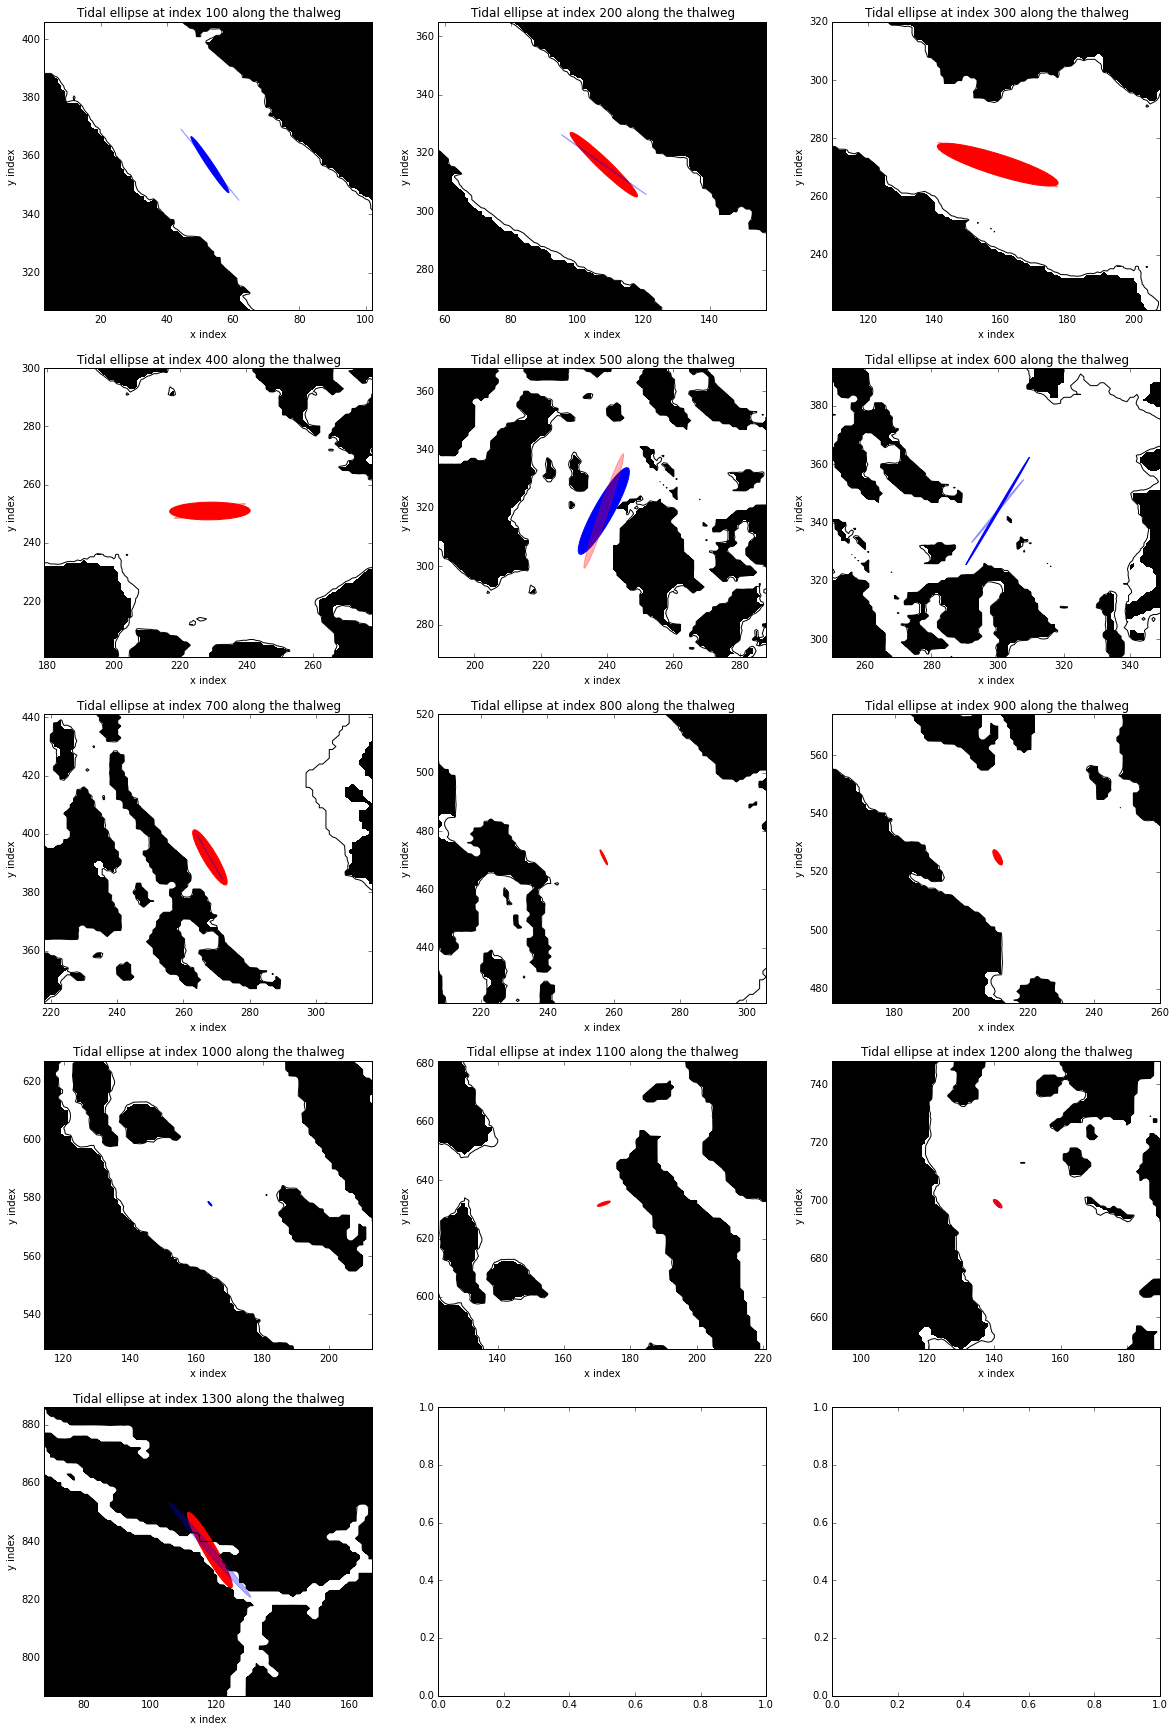

In [43]:

phi=0
fig, ax = plt.subplots(5 , 3, figsize=(20,30))
k = np.zeros((898,398))
m = np.zeros((898,398))
ex = 50



count = np.arange(1,14)
xes = [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2]
xis = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]
for a, b ,c, axis, axes in zip(i[1:], j[1:], count,xis, xes): 
    
    imin = a
    imax = a

    jmin = b
    jmax = b

    for q in np.arange(jmin-ex,jmax+ex):
        for l in np.arange(imin-ex,imax+ex):
            k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
            m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
    scale = 50


    
    #Making the ellipse Salish Sea Model
    if params[c,0,2] > 0:
         thec = 'b' 
    else:
        thec = 'r'
    ellsc1 = Ellipse(xy=(m[b,a],k[b,a]), width=scale*params[c,0,1], 
                            height=scale*params[c,0,2], angle=params[c,0,3]-29,
                            color=thec)
    ax[axis,axes].add_artist(ellsc1)
    ellsc1.set_facecolor(thec)

    #Making the ellipse Foreman model
    if params_t[c,1] > 0:
        thec = [0,0,1, 0.3]
    else:
        thec = [1,0,0, 0.3]
    ellsc = Ellipse(xy=(m[b,a],k[b,a]), width=scale*params_t[c,0], 
                            height=scale*params_t[c,1], angle=params_t[c,2]-29,
                            color=thec)
    ax[axis,axes].add_artist(ellsc)
    ellsc.set_facecolor(thec)
    # land, and 5 m contour
    contour_interval = [-0.01, 0.01]
    ax[axis,axes].contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
    ax[axis,axes].contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
                bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
    ax[axis,axes].set_title('Tidal ellipse at index {} along the thalweg'.format(c*100))
    ax[axis,axes].set_xlabel('x index')
    ax[axis,axes].set_ylabel('y index')
    


In [76]:
loc = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1400, 1500]
count = np.arange(0,14)
parameter = ['major-axis', 'minor-axis', 'inclination']
unit = ['m/s','m/s','deg']

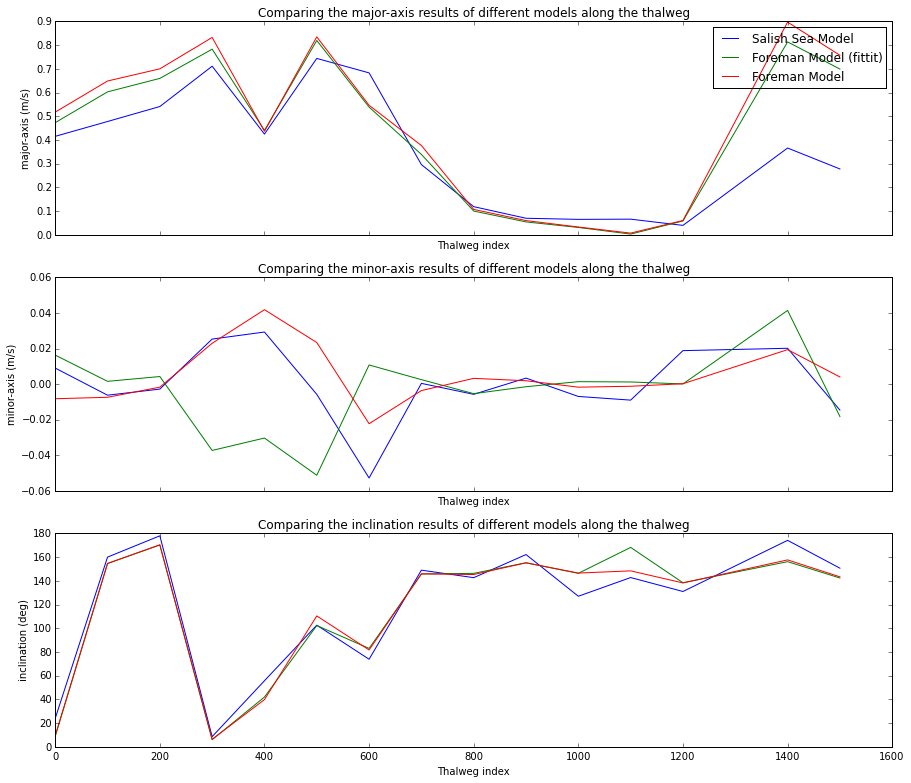

In [80]:
fig, (ax0, ax1, ax2)= plt.subplots(3,1,figsize=(15,13), sharex=True)

for ax , k, par, u in zip([ax0, ax1, ax2], np.arange(0,3), parameter, unit):
    ax.plot(loc[:],params_av[:,k], '-', label='Salish Sea Model')
    ax.plot(loc[:], params_t[:,k], '-', label='Foreman Model (fittit)')
    ax.plot(loc[:], param_ft[:,k], '-', label='Foreman Model')

    ax.set_title('Comparing the {} results of different models along the thalweg'.format(par))
    ax.set_xlabel('Thalweg index')
    ax.set_ylabel('{} ({})'.format(par,u))
ax0.legend()